In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [14]:
import csv
import sqlite3

query = (
    """
SELECT
    ro.id AS order_id,
    ro.datetime AS order_time,
    roi.quantity as quantity,
    rp.id as product_id,
    rp.price as price,
    rp.name as name
FROM
    restaurant_order AS ro
JOIN
    restaurant_orderitem AS roi on ro.id = roi.order_id
JOIN
    restaurant_product as rp on roi.product_id = rp.id
"""
)

with sqlite3.connect("..\db.sqlite3") as conn:
    cursor = conn.cursor()
    cursor.execute(query)

    rows = cursor.fetchall()
    with open("..\db_data.csv", 'w+', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow([description[0] for description in cursor.description])
        csv_writer.writerows(rows)

df = pd.read_csv("../db_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    74818 non-null  int64  
 1   order_time  74818 non-null  object 
 2   quantity    74818 non-null  int64  
 3   product_id  74818 non-null  int64  
 4   price       74818 non-null  float64
 5   name        74818 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ MB


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

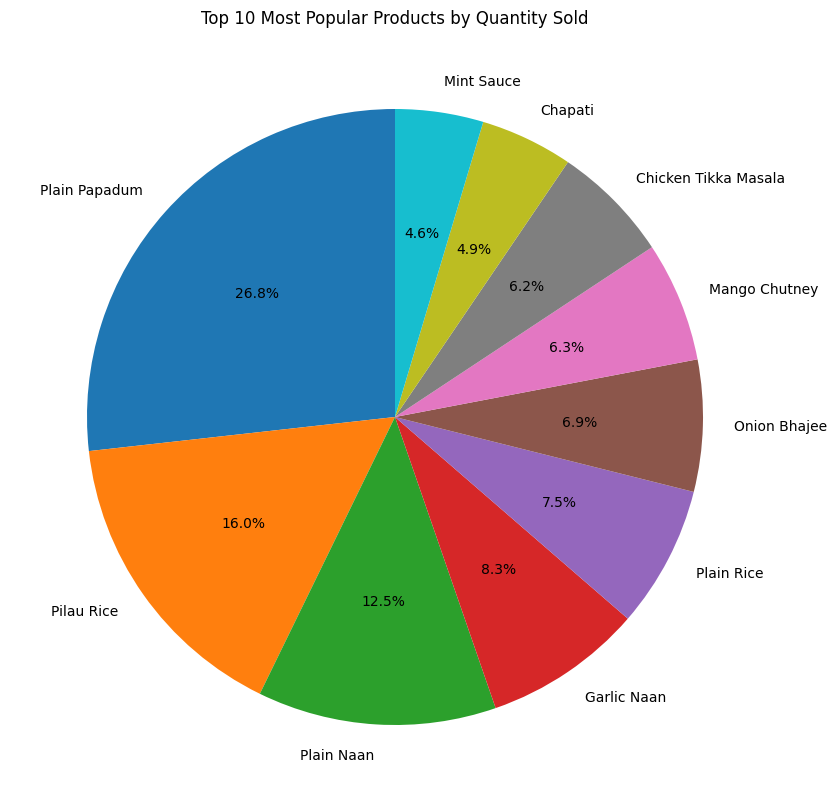

In [38]:
product_sales = df.groupby("name")["quantity"].sum()
top_10 = product_sales.nlargest(10)

percentage_popularity = (top_10 / top_10.sum()) * 100

plt.figure(figsize=(10, 10))
plt.pie(percentage_popularity, labels=percentage_popularity.index, autopct="%1.1f%%", startangle=90)
plt.title("Top 10 Most Popular Products by Quantity Sold")
plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

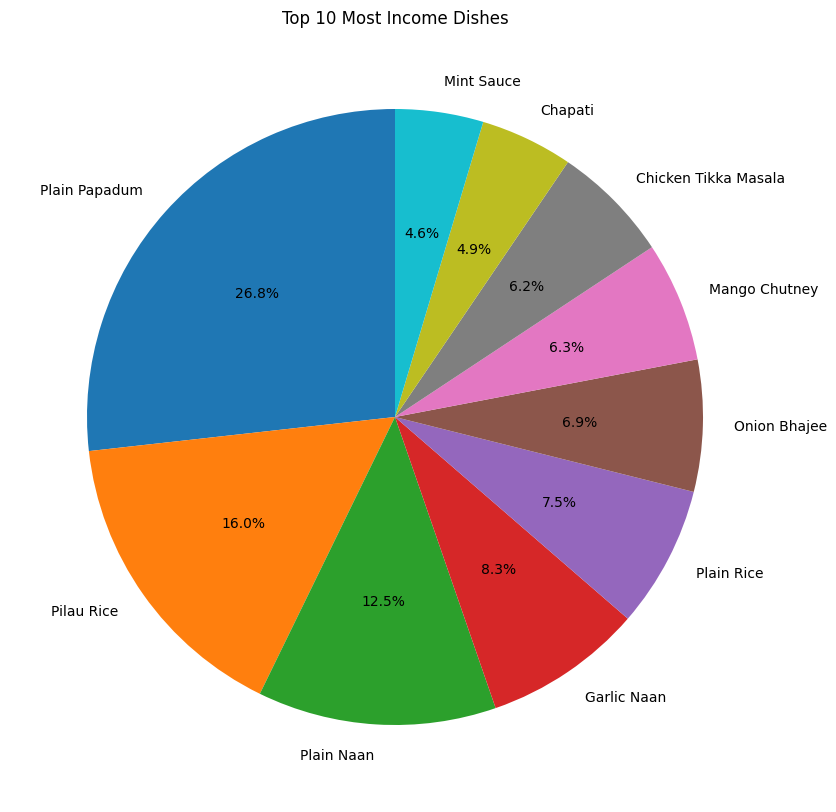

In [44]:
df["item price"] = df["quantity"] * df["price"]
top_10_sales = df["item price"].nlargest(10)

percentage_income = (top_10 / top_10.sum()) * 100

plt.figure(figsize=(10, 10))
plt.pie(percentage_income, labels=percentage_income.index, autopct="%1.1f%%", startangle=90)
plt.title("Top 10 Most Income Dishes")
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

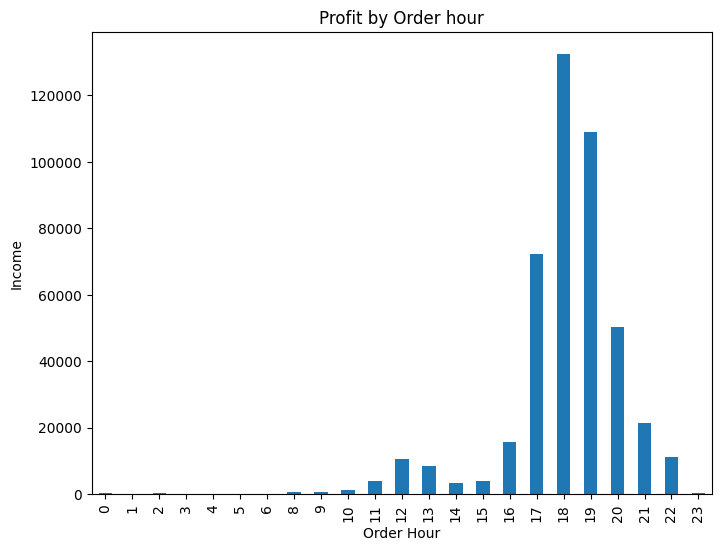

In [61]:
df["order_time"] = pd.to_datetime(df["order_time"])
df["order hour"] = df["order_time"].dt.hour
sales_by_hour = df.groupby("order hour")["item price"].sum()
sales_by_hour.plot(kind="bar", figsize=(8, 6))
plt.title("Profit by Order hour")
plt.xlabel("Order Hour")
plt.ylabel("Income")
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

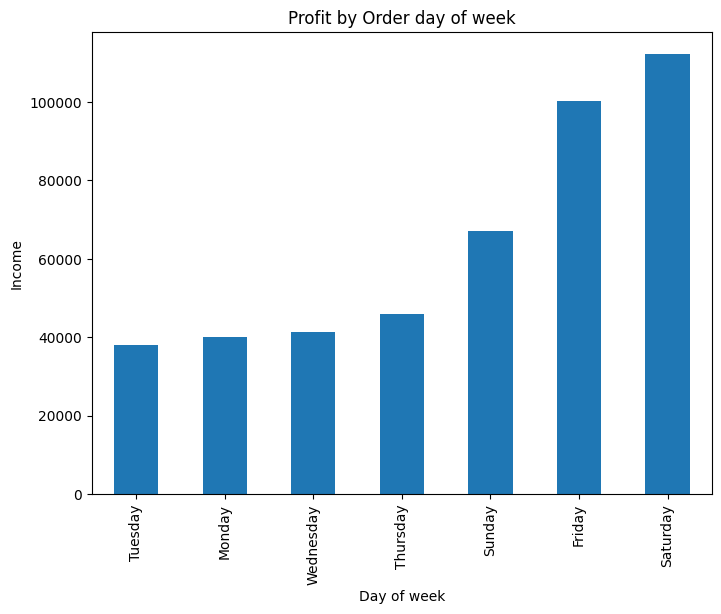

In [79]:
df["day of week"] = df["order_time"].dt.day_name()
sales_by_day = df.groupby("day of week")["item price"].sum().sort_values()
sales_by_day.plot(kind="bar", figsize=(8, 6))
plt.title("Profit by Order day of week")
plt.xlabel("Day of week")
plt.ylabel("Income")
plt.show()